In [17]:
import os
from os import listdir, path
import time
import shutil
import numpy as np 
import pandas as pd
from tqdm import tqdm
import random
from matplotlib import pyplot as plt
from PIL import Image

import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision.transforms.transforms import Compose, Resize, ToTensor, CenterCrop, Normalize
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR

%matplotlib inline

if_gpu = torch.cuda.is_available()
print("GPU is on?", if_gpu)

GPU is on? True


In [4]:
# Global variables
SOURCE_DIR = '../../GDrive/Datasets/PlantSeedlings'
STD_IMGSIZE = 64

In [5]:
def show_sample_images(root_dir='..\Datasets\PlantSeedlings',sample_size=16,from_class=None):
    '''
    Display sample images from input directory
    '''
    # number of images on the x and y axes should be relatively close
    for i in range(int(sample_size**0.5 + 1), 0, -1):
        if sample_size % i == 0:
            N_images_x = i
            N_images_y = int(sample_size/N_images_x)
            break
 
    # sample data directory and show image in subplots
    fig, ax = plt.subplots(N_images_x, N_images_y, squeeze=False)
    for sample_number in range(sample_size):
        if not from_class:
            labels_list = listdir(path.join(root_dir, 'train'))
            label = str(random.sample(labels_list, 1)[0])
        
        parent_directory = path.join(root_dir, 'train', label)
        file_list = listdir(parent_directory)
        file_name = random.sample(file_list, 1)[0]
        img = Image.open(path.join(parent_directory, file_name))
        ax[sample_number % N_images_x][sample_number // N_images_x].imshow(img)
        ax[sample_number % N_images_x][sample_number // N_images_x].title.set_text(label)
        
    fig.set_figheight(N_images_y * 4)
    fig.set_figwidth(N_images_y * 4)
    #fig.show()  

In [6]:
#show_sample_images(SOURCE_DIR)
os.listdir(path.join(SOURCE_DIR,'train'))

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [10]:
# Load all file names and classes in a DataFrame
def getImageList(root_dir):
    odf = pd.DataFrame(columns=['FileName','Class'])
    seedlingTypes = os.listdir(path.join(root_dir,'train'))
    for sType in seedlingTypes:
        ixClass = seedlingTypes.index(sType)
        fPath = path.join(root_dir, 'train', sType)
        file_list = os.listdir(fPath)
        tdf = pd.DataFrame(file_list,columns=['FileName'])
        tdf['Class'] = ixClass
        odf = odf.append(tdf)
    return(odf)

# Gets a balanced image list
def getBalancedList(source_df,test_size=0.15):
    capSize = source_df['Class'].value_counts().min()
    ClassList = source_df.Class.unique()
    odf = pd.DataFrame(columns=['FileName','Class'])
    for sType in ClassList:
        tdf = source_df[source_df['Class']==sType]
        odf = odf.append(tdf.sample(capSize))
    y = odf['Class']
    return(train_test_split(odf,test_size=test_size,stratify=y))

In [48]:
class SeedlingDataset(Dataset):
    def __init__(self,image_df,root_dir,transform=None):
        self.data = image_df
        self.root_dir = root_dir
        self.transform = transform
        self.seedlingTypes = os.listdir(path.join(root_dir,'train'))
        
    def __len__(self):
        return(len(self.data))
    
    def __getitem__(self,idx):
        imgFileName, imgLabel = self.data.iloc[idx]
        dirForLabel = self.seedlingTypes[imgLabel]
        img = Image.open(path.join(self.root_dir,'train', dirForLabel, imgFileName))
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        img = torch.from_numpy(np.array(img))
        label = torch.tensor(imgLabel)    
        return img, label
    
    def getClassNames(self):
        return self.seedlingTypes

In [15]:
def getDataLoaders(root_dir,batch_size,transforms,test_ratio=0.25):
    X_train, X_test  = getBalancedList(getImageList(root_dir),test_ratio)
    trainData = SeedlingDataset(X_train,root_dir,transforms)
    testData = SeedlingDataset(X_test,root_dir,transforms)
    trainLoader = DataLoader(trainData,batch_size=batch_size)
    testLoader = DataLoader(testData,batch_size=batch_size)
    return trainLoader, testLoader

In [25]:
class TinyModel(nn.Module):
    
    def __init__(self):
        super(TinyModel, self).__init__()
        self.bn1 = nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(5, 5))
        self.bn2 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(in_channels=10 , out_channels=10, kernel_size=(5, 5), stride=2)
        self.fc1 = nn.Linear(7840, 128)
        self.fc2 = nn.Linear(128, 12)
        
    def forward(self, x):
        x = F.relu(self.conv1(self.bn1(x)))
        x = F.relu(self.conv2(self.bn2(x)))
        x = x.view(-1, 7840)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)
    
    def loss(self, prediction, true_values):

        return F.nll_loss(prediction, true_values)

In [32]:
def train(model, device, train_dataloader, optimizer, epoch, verbose=False):
    model.train()
    total_loss = 0
    for batch_idx, (image, label) in enumerate(train_dataloader):
        input_var = image.to(device)
        target_var = label.to(device)
        optimizer.zero_grad()
        output = model(input_var)
        loss = model.loss(output, target_var)
        loss.backward()
        optimizer.step()
        total_loss += loss
        if batch_idx % 10 == 0 and verbose:
            print('Train Epoch: {0}, Train batch: {1}, Batch loss: {2}'
                  .format(epoch, batch_idx, loss))
    
    epoch_loss = total_loss/(batch_idx + 1)
    return epoch_loss

def test(model, device, test_dataloader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for image, label in test_dataloader:
            input_var = image.to(device)
            target_var = label.to(device)
            output = model(input_var)
            prediction = output.argmax(dim=1, keepdim=True)
            correct += prediction.eq(target_var.view_as(prediction)).sum().item()
    
    accuracy = correct / len(test_dataloader.dataset)
    
    return accuracy

In [46]:
# main
losses = []
accuracies = []
n_epochs = 20
learning_rate = 0.1
lr_decay = 5 # every 10 epochs, the learning rate is divided by 10
batch_size = 24
use_cuda = True # use True to switch to GPU

device = torch.device("cuda" if use_cuda else "cpu")
model = TinyModel().to(device)
print('The model has {0} parameters'.format(sum([len(i.reshape(-1)) for i in model.parameters()]) ))

data_transformers = Compose([Resize(STD_IMGSIZE), CenterCrop(STD_IMGSIZE), ToTensor()])
train_loader, test_loader = getDataLoaders(SOURCE_DIR, batch_size, data_transformers, test_ratio=0.1)
print('Number of train examples: {0}, number of test examles: {1}'
      .format(len(train_loader.dataset), len(test_loader.dataset)))

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = StepLR(optimizer, step_size=1, gamma=0.75)

for epoch in range(1, n_epochs + 1):
    tic = time.time()
    epoch_loss = train(model, device, train_loader, optimizer, epoch)
    print('Training loss for epoch {0} is {1:.5f}.   LR={2}'.format(epoch, epoch_loss,lr_scheduler.get_lr()))
    losses.append(epoch_loss)
    accuracy = test(model, device, test_loader)
    print('Test accuracy: {0:.3f}'.format(accuracy))
    accuracies.append(accuracy)
    lr_scheduler.step()
    tac = time.time()
    print('Epoch time: {0:0.1f} seconds'.format(tac - tic))

The model has 1008492 parameters
number of train examples: 2386, number of test examles: 266
Training loss for epoch 1 is 2.47587.   LR=[0.1]
Test accuracy: 0.158
Epoch time: 49.7 seconds
Training loss for epoch 2 is 2.07247.   LR=[0.07500000000000001]
Test accuracy: 0.305
Epoch time: 53.7 seconds
Training loss for epoch 3 is 1.50505.   LR=[0.05625]
Test accuracy: 0.459
Epoch time: 57.8 seconds
Training loss for epoch 4 is 1.02420.   LR=[0.0421875]
Test accuracy: 0.564
Epoch time: 59.0 seconds
Training loss for epoch 5 is 0.68727.   LR=[0.031640625]
Test accuracy: 0.575
Epoch time: 57.0 seconds
Training loss for epoch 6 is 0.45383.   LR=[0.02373046875]
Test accuracy: 0.635
Epoch time: 56.4 seconds
Training loss for epoch 7 is 0.28933.   LR=[0.0177978515625]
Test accuracy: 0.673
Epoch time: 55.9 seconds
Training loss for epoch 8 is 0.18691.   LR=[0.013348388671875001]
Test accuracy: 0.692
Epoch time: 64.2 seconds
Training loss for epoch 9 is 0.12156.   LR=[0.01001129150390625]
Test accu

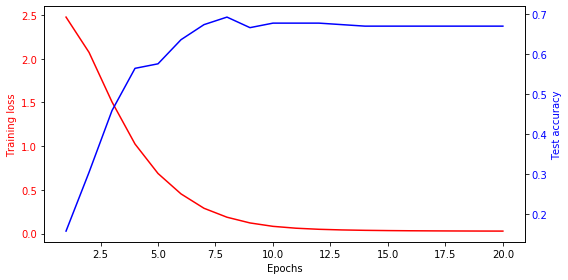

In [47]:
fig, ax1 = plt.subplots(figsize=(8,4))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss', color='r')
ax1.plot(range(1, n_epochs + 1), losses, color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.set_ylabel('Test accuracy', color='b')
ax2.plot(range(1, n_epochs + 1), accuracies, color='b')
ax2.tick_params(axis='y', labelcolor='b')
fig.tight_layout()
plt.show()

In [49]:
test_loader[0]

TypeError: 'DataLoader' object is not subscriptable